In [1]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [2]:
import kernel
import importlib
importlib.reload(cluster_model)
importlib.reload(kernel)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash bc59bc4fbdc5fbf0582034fc1f46b24d5a7e80f2
Created dataset
Loading dataset from cache
Got embeddings
Loading cluster scores from cache


In [3]:
decomp.lattice_scores[0].shape

(1024, 1024)

In [4]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

0.0
0.0


## Isolate Specific Neurons

In [5]:
LAYER = 0
NEURON = 128

In [6]:
import numpy as np
import kernel
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
import graph
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(graph)
importlib.reload(kernel)

N_CHECK = 4

decomp.scores_for_neuron(LAYER, NEURON, n_features_per_neuron=3)

WEIGHTING PER LAYER [1.      0.9     0.81    0.729   0.6561  0.59049] WEIGHTING PER EDGE [0.9     0.81    0.729   0.6561  0.59049]
Getting top 100 paths


/tmp/ipykernel_186210/1084699106.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


([128, 128, 128, 128, 128, 128], 1.8645901766395847)
([128, 47, 47, 47, 315, 395], 1.7855992268395846)
([128, 112, 47, 47, 315, 395], 1.7873209268395844)
([128, 47, 47, 47, 315, 346], 1.7822924828395845)
([128, 112, 47, 47, 315, 346], 1.7840141828395844)
([128, 47, 47, 315, 315, 395], 1.7790877988395846)
([128, 112, 47, 315, 315, 395], 1.7808094988395846)
([128, 47, 47, 47, 315, 474], 1.7795880386395846)
([128, 47, 47, 47, 315, 660], 1.7787377330395846)
([128, 112, 47, 47, 315, 474], 1.7813097386395844)
([128, 112, 47, 47, 315, 660], 1.7804594330395844)
([128, 47, 47, 315, 315, 346], 1.7757810548395845)
([128, 112, 47, 315, 315, 346], 1.7775027548395845)
([128, 47, 47, 315, 315, 474], 1.7730766106395845)
([128, 47, 47, 315, 315, 660], 1.7722263050395846)
([128, 112, 47, 315, 315, 474], 1.7747983106395846)
([128, 112, 47, 315, 315, 660], 1.7739480050395846)
([128, 957, 957, 957, 957, 957], 1.7417460410395846)
([128, 47, 47, 47, 315, 1000], 1.7668688840395845)
([128, 112, 47, 47, 315, 10

## Look at distributions of scores

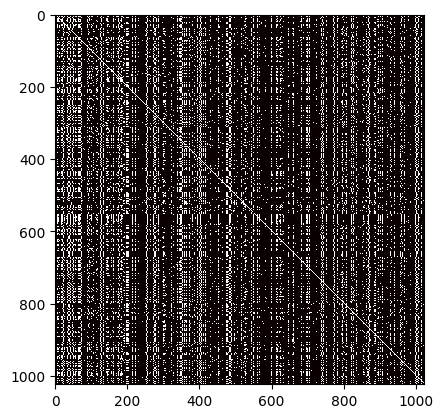

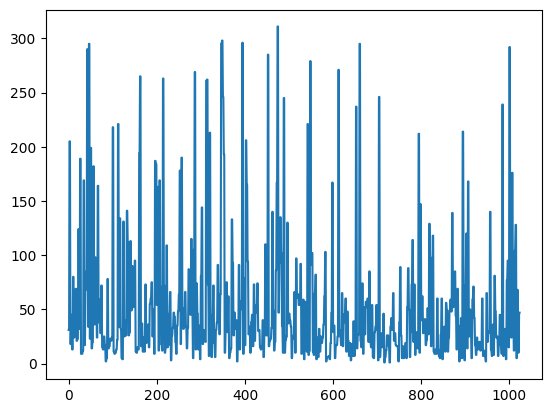

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.1

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))

## Get scores for layers

In [8]:
decomp.scores_for_layer(0)

WEIGHTING PER LAYER [1.      0.9     0.81    0.729   0.6561  0.59049] WEIGHTING PER EDGE [0.9     0.81    0.729   0.6561  0.59049]
Getting top 100 paths
([0, 957, 957, 957, 957, 957], 1.7612234502594086)
([0, 47, 47, 47, 315, 395], 1.7167866360594088)
([0, 956, 956, 956, 956, 956], 1.6971344502594086)
([0, 47, 47, 47, 315, 346], 1.7134798920594088)
([0, 47, 47, 315, 315, 395], 1.7102752080594088)
([0, 47, 47, 47, 315, 474], 1.7107754478594088)
([0, 47, 47, 47, 315, 660], 1.7099251422594088)
([0, 47, 47, 315, 315, 346], 1.7069684640594087)
([0, 47, 47, 315, 315, 474], 1.7042640198594088)
([0, 47, 47, 315, 315, 660], 1.7034137142594088)
([0, 47, 47, 47, 315, 1000], 1.6980562932594088)
([0, 47, 47, 47, 47, 347], 1.6963038501594088)
([0, 652, 652, 652, 652, 394], 1.6901943702594089)
([0, 47, 47, 315, 315, 1000], 1.6915448652594087)
([0, 47, 47, 47, 47, 475], 1.6925719533594088)
([0, 652, 652, 652, 652, 347], 1.685511784559409)
([0, 47, 47, 47, 47, 394], 1.691243350859409)
([0, 652, 652, 65

KeyboardInterrupt: 